# hurricane-net
Hammad Usmani
### A machine learning algorithm to forecast the intensity and trajectory of Atlantic tropical storms
[https://github.com/hammad93/hurricane-net](https://github.com/hammad93/hurricane-net)

### Table of Contents

1. [Background](#Background)
2. [Problem](#Problem)
3. [Datasets](#Datasets)
4. [Workflow Diagram](#Workflow)
5. [Data Extraction](#Extract)
6. [Data Transformation](#Transform)
7. [Data Loading](#Load)
8. [Feature Engineering](#FeatureEngineering)
9. [Model Architecture](#ModelArchitecture)
11. [Model Selection](#ModelSelection)
12. [Paramater Optimization](#Optimization)
13. [Model Evaluation & Benchmarks](#Benchmarks)
14. [Visualizations](#Visualizations)

![Hurricane Maria 2017](img/hurricane-maria.png "Hurricane Maria. Source: NOAA")

## Background<a id="Background"></a>

The National Hurricane Center (NHC) and National Oceanic and Atmospheric Administration (NOAA) provide predictions for storms trajectories, intensity, and size. They create these predictions based on models that can be classified into 3 groups: dynamical, statistical, and ensemble [1]. The most accurate models are based on computational fluid dynamics and achieve more precision than their statistical and ensemble counterparts [1][4]. The current statistical models (OCD5) are based on multiple regression methods that can explain a significant amount of variance [1]. In this project, we research and implement the domain of machine learning and deep learning into predictive hurricane models for both trajectory and intensity and evaluate them against the NHC standards. 
Previous research into machine learning to forecast tropical Atlantic storms include a sparse recurrent neural network (Kordmahalleh, Sefidmazgi, & Homaifar, 2016) and an artificial neural network (Jung & Das, 2013); both achieved favorable results. The hurricane models created can be utilized to develop more precise emergency planning. There is a necessity for more accurate and timely models that can help reduce the amount of loss caused by hurricanes. 

## Problem<a id="Problem"></a>

The NOAA and NHC have several different classifications for Atlantic hurricane models that describe feature prediction and model architecture. The 3 main classifications for hurricane model architecture include dynamical, statistical, and ensemble. Classifications also include relative compute time required to create an output grouped as either early or late and forecast parameters such as trajectory, intensity, and wind radii. The most accurate models are late models that take upwards of 6 hours to produce an output whereas models that can produce an output in seconds to minutes are called early. Early models tend to be statistical which include the baseline model for trajectory named CLIPER5 Climatology and Persistence (CLP5) utilizing multivariate regression. The performance for these methods can be augmented by incorporating more advanced statistical methods from deep learning such as recurrent neural networks. Kordmahalleh et al., 2016 created a sparse recurrent neural network augmented by a genetic algorithm but there are factors requiring improvement. The training set utilized an older version of the NHC Hurricane Database format known as HURDAT while a new format has been released called HURDAT2 with additional information on wind radii. Kordmahalleh et al., 2016 also utilized benchmarks different from the standard applied within the NHC. Other than improving their methodology, we can expand the scope by creating separate models for both intensity and trajectory. These models can be used to predict the trajectory and intensity for future Atlantic storms.

## Datasets<a id="Datasets"></a>

The following datasets and inputs including their sources will be used to create machine learning models:
- NHC Hurricane Database (HURDAT2)
    - http://www.nhc.noaa.gov/data/#hurdat
    - https://www.kaggle.com/noaa/hurricane-database
- NHC Forecast Error Database
    - http://www.nhc.noaa.gov/verification/verify7.shtml
- NHC GIS
    - http://www.nhc.noaa.gov/gis/
    
The NHC HURDAT2 database contains the tracking information for Atlantic tropical and subtropical cyclones which includes hurricanes and tropical storms from 1851 to 2016. The most updated version of the dataset is included on the noaa.gov site and includes 2 additional years of cyclone data compared to the data set available on Kaggle and is potentially more descriptive. To match the inputs of the baseline model used by the NHC, we are calculating the forward motion of the storm by applying a vector based on previous and current geographical location.

*Table 1. This table contains the tentative features as input to the model*

| **Name**         | **Data Type** | **Description**                                                     |
|------------------|---------------|---------------------------------------------------------------------|
| Time             | Date Time     | The date and time of the measurement.                               |
| Latitude         | Float         | The geographical latitude of the storm eye to 1 decimal precision.  |
| Longitude        | Float         | The geographical longitude of the storm eye to 1 decimal precision. |
| Maximum Winds    | Integer       | The maximum sustained winds within the storm.                       |
| Minimum Pressure | Integer       | The minimum barometric pressure within the storm.                   |
| Forward Motion   | String        | Calculated vector of motion based on location in time series.       |

The Forecast Error Database contains information on the accuracy of predicted models from the NHC. The two model forecast errors available are labeled OFCL and BCD5. The OFCL is the official NHC forecast and the BCD5 is the real track available. This data set can be used to benchmark and evaluate the deep learning model. 
The NOAA and NHC also hosts a geographical information system (GIS) that contains raw and processed data on hurricanes. The server hosting the GIS is publicly accessible and can be used to evaluate our model by comparing the 2017 Atlantic tropical season. The preliminary best tracks can be found here before they are finalized and available in the HURDAT2 data set. With the GIS, we can construct a final evaluation data set.

*Diagram 1. This graphic describes the workflow for the deep learning models*.<a id="Workflow"></a>
![Data Pipeline](img/Deep Learning Workflow.png "hurricane-net Data Pipeline")

## Extract Data<a id="Extract"></a>

*The following code uses the hurdat2 and models modules created to provide a class interface for the HURDAT2 and error forecast database located in the data and models folder. *

We will begin our steps to perform extraction, transformation, and loading of our data for analysis or broadly known as ETL. Although we're dividing these steps into disctinct procedures, they are often more fluid and often have overlaps. The extraction phase consists of collecting and parsing the HURDAT2 and error forecast databases for analysis and benchmarking. The HURDAT2 database is our core foundation for creating the deep learning model. We store the database in its raw .txt format but it can be directly linked to the database hosted by the NHC.

In [1]:
# Import various libraries throughout the software
from pprint import pprint
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Import from hurdat2 class in data folder and models class from hurricane-models folder
from data.hurdat2 import hurdat2
from errors.models import models

# Initialize Dataframe for hurricanes and error database
dataset = hurdat2("data/hurdat2.txt")
errors = models("errors/1970-present_OFCL_v_BCD5_ind_ATL_TI_errors_noTDs.txt")

# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.hurricanes.query('storm_id == "AL122005"').head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
44063,AL122005,KATRINA,2005-08-23 18:00:00,,TD,23.1N,75.1W,30,1008,0,...,0,0,0,0,0,0,0,0,0,0
44064,AL122005,KATRINA,2005-08-24 00:00:00,,TD,23.4N,75.7W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44065,AL122005,KATRINA,2005-08-24 06:00:00,,TD,23.8N,76.2W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44066,AL122005,KATRINA,2005-08-24 12:00:00,,TS,24.5N,76.5W,35,1006,60,...,0,0,0,0,0,0,0,0,0,0
44067,AL122005,KATRINA,2005-08-24 18:00:00,,TS,25.4N,76.9W,40,1003,60,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Show the first 3 OFCL hurricane model errors for Hurricane Katrina 2005 on 28-08-2005/18:00:00
pprint(errors.models['OFCL'].storm['AL122005'][datetime.datetime(2005, 8, 28, 18, 0)], indent = 8)

{       'intensity_forecast': {       datetime.datetime(2005, 8, 28, 18, 0): 0.0,
                                      datetime.datetime(2005, 8, 29, 6, 0): 20.9,
                                      datetime.datetime(2005, 8, 29, 18, 0): 93.6,
                                      datetime.datetime(2005, 8, 30, 6, 0): 170.2,
                                      datetime.datetime(2005, 8, 30, 18, 0): None,
                                      datetime.datetime(2005, 8, 31, 18, 0): None,
                                      datetime.datetime(2005, 9, 1, 18, 0): None,
                                      datetime.datetime(2005, 9, 2, 18, 0): None,
                                      datetime.datetime(2005, 9, 3, 18, 0): None,
                                      datetime.datetime(2005, 9, 4, 18, 0): None},
        'lat': 26.3,
        'long': 88.6,
        'sample_sizes': {       'F012': 0.33,
                                'F024': 0.33,
                                'F036': 

## Transform Data<a id="Transform"></a>

The following code will tranform the hurricane best path data into objects that can be better manipulated for processing. to match between datasets, we will also create a `storm_id` dictionary to store storm names matched with ID's.

In [3]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add hurricane track entry based on standard HURDAT2 format
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : None if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
            }
        }
        self.entries.update(entry)
        
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return
# Storm ID Key for matching between datasets
storm_id = dict()

# Parse in hurricanes
hurricanes = dict()
for index, entry in dataset.hurricanes.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset.hurricanes)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_id[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])

Transforming 1275/49691 entries from HURDAT2

Transforming 2895/49691 entries from HURDAT2

Transforming 4135/49691 entries from HURDAT2

Transforming 5892/49691 entries from HURDAT2

Transforming 7008/49691 entries from HURDAT2

Transforming 7890/49691 entries from HURDAT2

Transforming 9360/49691 entries from HURDAT2

Transforming 10572/49691 entries from HURDAT2

Transforming 11387/49691 entries from HURDAT2

Transforming 12345/49691 entries from HURDAT2

Transforming 14088/49691 entries from HURDAT2

Transforming 16383/49691 entries from HURDAT2

Transforming 17882/49691 entries from HURDAT2

Transforming 20051/49691 entries from HURDAT2

Transforming 21380/49691 entries from HURDAT2

Transforming 22790/49691 entries from HURDAT2

Transforming 23649/49691 entries from HURDAT2

Transforming 25818/49691 entries from HURDAT2

Transforming 27869/49691 entries from HURDAT2

Transforming 30413/49691 entries from HURDAT2

Transforming 32638/49691 entries from HURDAT2

Transforming 33909/49691 entries from HURDAT2

Transforming 34274/49691 entries from HURDAT2

Transforming 35418/49691 entries from HURDAT2

## Load Data<a id="Load"></a>

The following will finalize our preliminary data preparation by loading some of the errors into each hurricane object. Note that models start from the year 1970 and any hurricane before that has no previous model data.

In [4]:
# Get all available model errors
models = errors.models.keys()
# Load model errors into hurricanes
for id in storm_id :
    for model in models :
        # Skip if this hurricane does not have the model
        if id not in errors.models[model].storm :
            continue
        hurricanes[id].add_model(model, errors.models[model].storm[id])

## Feature Engineering & Data Augmentation<a id="FeatureEngineering"></a>

The following section will extract the relevant features and engineer each data point so that we can fit it into the model. Because the type of inputs are important, the features will be transformed based on the model architecture. This will also include data augmentation methods. The higher level architecture will be a deep learning recurrent neural network with LSTM and time distributed layers.

The current statistical baseline model using multivariate regression uses multiple predictors as input. According to Knaff 2013, the following predictors were calculated for their intensity model that were not included in the HURDAT2 database. These features can be calculated from the data loaded into our current object model.

1. Date Information
2. Zonal Speed Of The Storm (U) (kt)
3. Meridional Speed Of The Storm (V) (kt)
4. 12-h Change In Intensity (DVMX) (kt)

The date information will "constructed from the yearday minus the yearday corresponding to the peak of the seasonal activity in that basin (Neumann 1993)." (Knaff 2003). The shape on the input to the LSTM will be in a 3D array with the format [samples, timestamps, features]. We will intitially begin with 1 time step and evaluate more can benefit our model. The output requires a 5 day forecast and observations without track data 5 days in the future will not be used.

In [5]:
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    '''
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'delta_wind' : (timestep['max_wind'] - previous['max_wind']) / # Calculated from track (12h)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'min_pressure' : timestep['min_pressure'],
        'date' : (timestep['entry_time'].date()
                  - datetime.date(timestep['entry_time'].year, 9, 10)).days, # Calendar days from 9/10 
        'zonal_speed' : (timestep['lat'] - previous['lat'])/ # Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'meridonal_speed' : (timestep['long'] - previous['long'])/# Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600)
    }
    return features
    
def storm_x_y(storm, timesteps = 1, lag = 24) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    # Create testing data structure with a dictionary
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    y = dict([(time,[]) for time in times])
    
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
        x.append(sample) # Add our constructed sample
        
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            if timestep and previous: 
                y[future].append(feature_extraction(timestep, previous))
            else :
                y[future].append(None)
    
    # Return output, if there is no output, return None.
    if len(x) is 0 :
        return None
    else:
        return {'x': x, 'y': y}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 8) where 8 is the number of predictors in a hurricane object
    '''
    x = []
    y = []
    lag = 24 # lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    
    return {'x': np.array(x), 'y': np.array(y)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    
    # Scale our data
    for index in range(len(processed_data['x'])) :
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 5)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

Feature engineered 1830/1830 hurricanes for 5 timestep(s)
Done feature engineering hurricanes.
Scaling Data . . . (1 timestep for unqiue data)
Feature engineered 1830/1830 hurricanes for 1 timestep(s)
Done feature engineering hurricanes.
Done scaling.


## Model Architecture<a id="ModelArchitecture"></a>

Following feature engineering, we are now ready to input our data into a machine learning algorithm. The scope of this project will attempt a deep learning approach to forecasting Atlantic tropical cyclones. We will experiment with nunermous different architectures but we will focus around a Recurrent Neural Network utilizing LSTM cells.

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn import model_selection

# Create our cross validation data structure
X_train, X_test, y_train, y_test = model_selection.train_test_split(processed_data['x'], processed_data['y'],
                                                                    test_size = 0.2)

# Train for wind intensity
y_train_wind = np.array([[[features[2]] for features in y] for y in y_train], dtype = np.float64)
y_test_wind = np.array([[[features[2]] for features in y] for y in y_test], dtype = np.float64)

# Train for latitude and longitude location
y_train_lat = np.array([[[features[0]] for features in y] for y in y_train], dtype = np.float64)
y_test_lat = np.array([[[features[0]] for features in y] for y in y_test], dtype = np.float64)
y_train_long = np.array([[[features[1]] for features in y] for y in y_train], dtype = np.float64)
y_test_long = np.array([[[features[1]] for features in y] for y in y_test], dtype = np.float64)


def bd_lstm_td(X_train, y_train, X_test, y_test, n_epochs = 500) :
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 1024, return_sequences = True, dropout = 0.05), input_shape = (5,8)))
    model.add(LSTM(units = 512, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mae', optimizer='adam')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

def lstm_td(X_train, X_test, y_train, y_test) :
    model = Sequential()
    model.add(LSTM(units = 1024, input_shape = (5,8), return_sequences = True))
    model.add(TimeDistributed(Dense(8)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    model.fit(X_train, y_train, batch_size = len(X_train), epochs = 300)
    
    return model

model_wind, model_wind_history = bd_lstm_td(X_train, y_train_wind, X_test, y_test_wind)
model_lat, model_lat_history = bd_lstm_td(X_train, y_train_lat, X_test, y_test_lat)
model_long, model_long_history = bd_lstm_td(X_train, y_train_long, X_test, y_test_long)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 5, 2048)           8462336   
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 512)            5244928   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              513       
Total params: 13,707,777
Trainable params: 13,707,777
Non-trainable params: 0
_________________________________________________________________
None
Train on 3298 samples, validate on 825 samples
Epoch 1/500
3298/3298 [==============================] - 3s 985us/step - loss: 0.7075 - val_loss: 0.6128
Epoch 2/500
3298/3298 [==============================] - 1s 296us/step - loss: 0.6076 - val_loss: 0.5968
Epoch 3/500
3298/3298 [==============================] - 1s 298us/step - loss: 0.5927 - val_loss: 0.5694
Epoch 4/500
3298/3298 [====

Epoch 71/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.4260 - val_loss: 0.4261
Epoch 72/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.4234 - val_loss: 0.4259
Epoch 73/500
3298/3298 [==============================] - 1s 303us/step - loss: 0.4239 - val_loss: 0.4278
Epoch 74/500
3298/3298 [==============================] - 1s 302us/step - loss: 0.4233 - val_loss: 0.4254
Epoch 75/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.4230 - val_loss: 0.4227
Epoch 76/500
3298/3298 [==============================] - 1s 303us/step - loss: 0.4228 - val_loss: 0.4265
Epoch 77/500
3298/3298 [==============================] - 1s 301us/step - loss: 0.4223 - val_loss: 0.4255
Epoch 78/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.4224 - val_loss: 0.4209
Epoch 79/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.4206 - val_loss: 0.4224
Epoch 80/500
3298/3298 [======================

Epoch 148/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.3660 - val_loss: 0.3831
Epoch 149/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.3626 - val_loss: 0.3900
Epoch 150/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.3658 - val_loss: 0.3816
Epoch 151/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.3608 - val_loss: 0.3818
Epoch 152/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.3593 - val_loss: 0.3882
Epoch 153/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.3623 - val_loss: 0.3808
Epoch 154/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.3616 - val_loss: 0.3798
Epoch 155/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.3587 - val_loss: 0.3820
Epoch 156/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.3577 - val_loss: 0.3762
Epoch 157/500
3298/3298 [============

Epoch 225/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2729 - val_loss: 0.2998
Epoch 226/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2675 - val_loss: 0.3037
Epoch 227/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2594 - val_loss: 0.3055
Epoch 228/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2608 - val_loss: 0.2949
Epoch 229/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.2626 - val_loss: 0.2991
Epoch 230/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.2548 - val_loss: 0.3017
Epoch 231/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2614 - val_loss: 0.2928
Epoch 232/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.2562 - val_loss: 0.2947
Epoch 233/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2583 - val_loss: 0.2976
Epoch 234/500
3298/3298 [============

Epoch 302/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1812 - val_loss: 0.2278
Epoch 303/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1893 - val_loss: 0.2218
Epoch 304/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1800 - val_loss: 0.2192
Epoch 305/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1811 - val_loss: 0.2242
Epoch 306/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1789 - val_loss: 0.2226
Epoch 307/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1794 - val_loss: 0.2239
Epoch 308/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1812 - val_loss: 0.2207
Epoch 309/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1830 - val_loss: 0.2208
Epoch 310/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1750 - val_loss: 0.2212
Epoch 311/500
3298/3298 [============

Epoch 379/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1455 - val_loss: 0.1873
Epoch 380/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1443 - val_loss: 0.1863
Epoch 381/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1379 - val_loss: 0.1888
Epoch 382/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1378 - val_loss: 0.1864
Epoch 383/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1399 - val_loss: 0.1926
Epoch 384/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1418 - val_loss: 0.1902
Epoch 385/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1389 - val_loss: 0.1888
Epoch 386/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1348 - val_loss: 0.1872
Epoch 387/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1381 - val_loss: 0.1878
Epoch 388/500
3298/3298 [============

Epoch 456/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1159 - val_loss: 0.1728
Epoch 457/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1214 - val_loss: 0.1775
Epoch 458/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1240 - val_loss: 0.1707
Epoch 459/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1169 - val_loss: 0.1705
Epoch 460/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1139 - val_loss: 0.1752
Epoch 461/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1213 - val_loss: 0.1716
Epoch 462/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1160 - val_loss: 0.1725
Epoch 463/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1129 - val_loss: 0.1716
Epoch 464/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1173 - val_loss: 0.1710
Epoch 465/500
3298/3298 [============

Epoch 26/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2854 - val_loss: 0.2682
Epoch 27/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2824 - val_loss: 0.2666
Epoch 28/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.2788 - val_loss: 0.2659
Epoch 29/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2769 - val_loss: 0.2632
Epoch 30/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2744 - val_loss: 0.2618
Epoch 31/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2722 - val_loss: 0.2628
Epoch 32/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.2714 - val_loss: 0.2620
Epoch 33/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.2720 - val_loss: 0.2599
Epoch 34/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2680 - val_loss: 0.2588
Epoch 35/500
3298/3298 [======================

Epoch 104/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2467 - val_loss: 0.2367
Epoch 105/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.2466 - val_loss: 0.2358
Epoch 106/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2460 - val_loss: 0.2387
Epoch 107/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2442 - val_loss: 0.2368
Epoch 108/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2459 - val_loss: 0.2351
Epoch 109/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2443 - val_loss: 0.2368
Epoch 110/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.2457 - val_loss: 0.2363
Epoch 111/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2444 - val_loss: 0.2345
Epoch 112/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2435 - val_loss: 0.2350
Epoch 113/500
3298/3298 [============

Epoch 181/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.2147 - val_loss: 0.2156
Epoch 182/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.2176 - val_loss: 0.2167
Epoch 183/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.2147 - val_loss: 0.2135
Epoch 184/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2129 - val_loss: 0.2121
Epoch 185/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.2135 - val_loss: 0.2147
Epoch 186/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.2163 - val_loss: 0.2161
Epoch 187/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2182 - val_loss: 0.2148
Epoch 188/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.2187 - val_loss: 0.2123
Epoch 189/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.2129 - val_loss: 0.2117
Epoch 190/500
3298/3298 [============

Epoch 258/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1773 - val_loss: 0.1870
Epoch 259/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1780 - val_loss: 0.1913
Epoch 260/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1831 - val_loss: 0.1896
Epoch 261/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1791 - val_loss: 0.1868
Epoch 262/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1809 - val_loss: 0.1889
Epoch 263/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1799 - val_loss: 0.1890
Epoch 264/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1795 - val_loss: 0.1835
Epoch 265/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1753 - val_loss: 0.1820
Epoch 266/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1731 - val_loss: 0.1879
Epoch 267/500
3298/3298 [============

Epoch 335/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1365 - val_loss: 0.1528
Epoch 336/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1378 - val_loss: 0.1550
Epoch 337/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1395 - val_loss: 0.1540
Epoch 338/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1380 - val_loss: 0.1549
Epoch 339/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1386 - val_loss: 0.1575
Epoch 340/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1431 - val_loss: 0.1554
Epoch 341/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1404 - val_loss: 0.1558
Epoch 342/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1407 - val_loss: 0.1524
Epoch 343/500
3298/3298 [==============================] - 1s 313us/step - loss: 0.1368 - val_loss: 0.1523
Epoch 344/500
3298/3298 [============

Epoch 412/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1198 - val_loss: 0.1323
Epoch 413/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1173 - val_loss: 0.1255
Epoch 414/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1123 - val_loss: 0.1228
Epoch 415/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1082 - val_loss: 0.1265
Epoch 416/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1071 - val_loss: 0.1265
Epoch 417/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1139 - val_loss: 0.1304
Epoch 418/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1112 - val_loss: 0.1323
Epoch 419/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.1182 - val_loss: 0.1228
Epoch 420/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1089 - val_loss: 0.1285
Epoch 421/500
3298/3298 [============

Epoch 489/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.0937 - val_loss: 0.1085
Epoch 490/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.0902 - val_loss: 0.1087
Epoch 491/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.0899 - val_loss: 0.1039
Epoch 492/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.0894 - val_loss: 0.1087
Epoch 493/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.0894 - val_loss: 0.1070
Epoch 494/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.0867 - val_loss: 0.1060
Epoch 495/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.0890 - val_loss: 0.1096
Epoch 496/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.0876 - val_loss: 0.1066
Epoch 497/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.0927 - val_loss: 0.1118
Epoch 498/500
3298/3298 [============

Epoch 59/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1873 - val_loss: 0.1805
Epoch 60/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1869 - val_loss: 0.1789
Epoch 61/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1873 - val_loss: 0.1778
Epoch 62/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.1866 - val_loss: 0.1781
Epoch 63/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1865 - val_loss: 0.1791
Epoch 64/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.1873 - val_loss: 0.1794
Epoch 65/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1837 - val_loss: 0.1785
Epoch 66/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1840 - val_loss: 0.1779
Epoch 67/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1852 - val_loss: 0.1782
Epoch 68/500
3298/3298 [======================

Epoch 136/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1692 - val_loss: 0.1663
Epoch 137/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.1714 - val_loss: 0.1644
Epoch 138/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1703 - val_loss: 0.1659
Epoch 139/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1708 - val_loss: 0.1660
Epoch 140/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1710 - val_loss: 0.1645
Epoch 141/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1687 - val_loss: 0.1641
Epoch 142/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1697 - val_loss: 0.1648
Epoch 143/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1697 - val_loss: 0.1657
Epoch 144/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1699 - val_loss: 0.1634
Epoch 145/500
3298/3298 [============

Epoch 213/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1531 - val_loss: 0.1502
Epoch 214/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1501 - val_loss: 0.1508
Epoch 215/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1495 - val_loss: 0.1545
Epoch 216/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1526 - val_loss: 0.1516
Epoch 217/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1538 - val_loss: 0.1491
Epoch 218/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1481 - val_loss: 0.1544
Epoch 219/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1542 - val_loss: 0.1529
Epoch 220/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.1518 - val_loss: 0.1495
Epoch 221/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1512 - val_loss: 0.1498
Epoch 222/500
3298/3298 [============

Epoch 290/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1320 - val_loss: 0.1341
Epoch 291/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1285 - val_loss: 0.1374
Epoch 292/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1276 - val_loss: 0.1349
Epoch 293/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1298 - val_loss: 0.1335
Epoch 294/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1284 - val_loss: 0.1368
Epoch 295/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1291 - val_loss: 0.1335
Epoch 296/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1280 - val_loss: 0.1327
Epoch 297/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1266 - val_loss: 0.1359
Epoch 298/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1271 - val_loss: 0.1327
Epoch 299/500
3298/3298 [============

Epoch 367/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1081 - val_loss: 0.1262
Epoch 368/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1157 - val_loss: 0.1178
Epoch 369/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1083 - val_loss: 0.1183
Epoch 370/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.1067 - val_loss: 0.1231
Epoch 371/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1084 - val_loss: 0.1167
Epoch 372/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1040 - val_loss: 0.1161
Epoch 373/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1091 - val_loss: 0.1225
Epoch 374/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1072 - val_loss: 0.1164
Epoch 375/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.1055 - val_loss: 0.1165
Epoch 376/500
3298/3298 [============

Epoch 444/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.0896 - val_loss: 0.0976
Epoch 445/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.0909 - val_loss: 0.1067
Epoch 446/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.0900 - val_loss: 0.0993
Epoch 447/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.0875 - val_loss: 0.0990
Epoch 448/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.0858 - val_loss: 0.1025
Epoch 449/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.0879 - val_loss: 0.0989
Epoch 450/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.0918 - val_loss: 0.1061
Epoch 451/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.0943 - val_loss: 0.1015
Epoch 452/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.0878 - val_loss: 0.0980
Epoch 453/500
3298/3298 [============

## Model Selection<a id="Selection"></a>
The following models were compared
- Bidirectional LSTM with Time Distributed(Best performance)
- LSTM with Time Distributed
- MLP
- Bidirectional GRU with Time Distributed

Wind


,0
count,4125.000000
mean,0.121529
std,3.128554
min,-20.156098
25%,-1.099284
50%,0.137199
75%,1.496002
max,27.496705


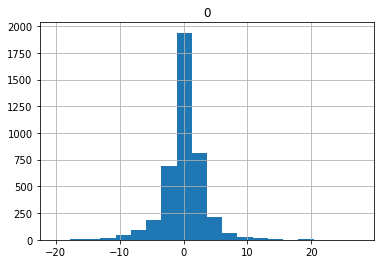

In [7]:
def ai_errors(predictions, observations) :
    '''
    PURPOSE: Provide descriptive statistics on the predicted output versus the observed measurments
    METHOD:  Take the errors of the predictions and answers and then calculate standard descriptive statistics
    INPUT:   predictions - 2D array of predictions of observed output
             observations - 2D array measurements of observed output
    OUTPUT:
    '''
    errors = []
    for i in range(len(predictions)) :
        for j in range(len(predictions[i])) :
            # Calculate errors
            error = predictions[i][j] - observations[i][j]
            errors.append(error)
            
    # Put into DataFrame for simpler processing
    errors = pd.DataFrame(errors)
    errors.describe()
    errors.hist(bins = 20)
    return errors

# Predict values
wind_predictions = model_wind.predict(X_test)
lat_predictions = model_lat.predict(X_test)
long_predictions = model_long.predict(X_test)

# Scale back our predictions
# Wind
wind_predictions_scaled = [scaler.inverse_transform([[winds[0],0,0,0,0,0,0,0] for winds in prediction])
                           for prediction in wind_predictions]
y_wind_test_scaled = [scaler.inverse_transform([[winds[0],0,0,0,0,0,0,0] for winds in observation])
                      for observation in y_test_wind]
# Latitude
lat_predictions_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0] for lat in prediction])
                          for prediction in lat_predictions]
y_lat_test_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0] for lat in observation])
                     for observation in y_test_lat]
# Longitude
long_predictions_scaled = [scaler.inverse_transform([[long[0],0,0,0,0,0,0,0] for long in prediction])
                           for prediction in long_predictions]
y_long_test_scaled = [scaler.inverse_transform([[long[0],0,0,0,0,0,0,0] for long in observation])
                      for observation in y_test_long]

# Record wind predictions and observations
print("Wind")
wind_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in wind_predictions_scaled]
wind_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_wind_test_scaled]
ai_errors(wind_predictions, wind_observations).describe()

Lat


,0
count,4125.000000
mean,-0.015399
std,2.085475
min,-18.907877
25%,-0.836236
50%,0.092917
75%,0.975679
max,9.184418


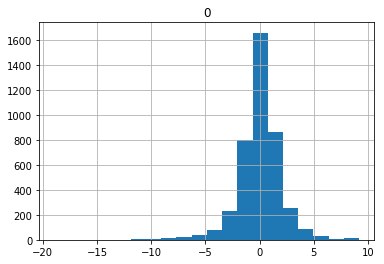

In [8]:
print("Lat")
lat_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in lat_predictions_scaled]
lat_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_lat_test_scaled]
ai_errors(lat_predictions, lat_observations).describe()

Long


,0
count,4125.000000
mean,-0.372034
std,1.804271
min,-13.116576
25%,-1.059632
50%,-0.350439
75%,0.305590
max,13.152066


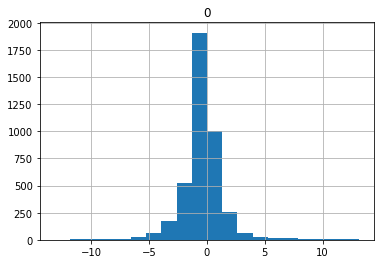

In [9]:
print("Long")
long_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in long_predictions_scaled]
long_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_long_test_scaled]
ai_errors(long_predictions, long_observations).describe()

## Model Evaluation & Benchmarks<a id="Benchmarks"></a>

The machine learning neural network will use 2 main methods of applied evaluation. The first will be evaluated compared to the other models that predict Atlantic hurricanes. The forecast errors have been loaded into each hurricane object corresponding to their forecast model; both the OFCL (official track, or the truth) and the BCD5 (model using multivariate regression).

In [10]:
import dateutil
# Get the Timestamp('2005-08-27 12:00:00') for hurricane Katrina
katrina_state = hurricanes['AL122005'].entries[dateutil.parser.parse('2005-08-27 12:00:00')]